In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow
import os

In [ ]:
%cd /content/drive/MyDrive/mosaic/
root = "/content/drive/MyDrive/mosaic/"

/content/drive/MyDrive/mosaic


In [ ]:
data_dir = root + "emoji_dataset/"

In [ ]:
batch_size = 32

In [ ]:
def random_dots(img, max_dots=20):
  n = tf.random.uniform(shape=[1],minval=0,maxval=max_dots,dtype=tf.dtypes.int32).numpy()
  x = tf.random.uniform(shape=n,minval=0,maxval=img.shape[0]+1,dtype=tf.dtypes.int32).numpy()
  y = tf.random.uniform(shape=n,minval=0,maxval=img.shape[1]+1,dtype=tf.dtypes.int32).numpy()
  for i in range(len(x)):
      thick = tf.random.uniform(shape=[1],minval=0,maxval=4,dtype=tf.dtypes.int32).numpy()[0]
      img = cv2.circle(img, (x[i],y[i]), thick, (255,255,255), -1)
  return img

def dilate(img):
  ker = int(tf.random.uniform(shape=[1],minval=3,maxval=11,dtype=tf.dtypes.int32).numpy()[0])
  it = int(tf.random.uniform(shape=[1],minval=1,maxval=4,dtype=tf.dtypes.int32).numpy()[0])
  img = cv2.dilate(img, np.ones((ker,ker),np.uint8),it)
  return img

def my_lambda_func(x):
  return tf.py_function(random_dots, [x], tf.float32)

In [ ]:
'''i = 0
for dir1 in os.listdir(data_dir):
  for dir2 in os.listdir(os.path.join(data_dir, dir1)):
    img_path = os.path.join(data_dir, dir1, dir2)
    try:
      img = 255 - cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      img = 255 - random_dots(img)
      cv2.imwrite(os.path.join(data_dir,dir1,"aug"+str(i)+".jpg"), img)
      i+=1
    except:
      pass'''

'i = 0\nfor dir1 in os.listdir(data_dir):\n  for dir2 in os.listdir(os.path.join(data_dir, dir1)):\n    img_path = os.path.join(data_dir, dir1, dir2)\n    try:\n      img = 255 - cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)\n      img = 255 - random_dots(img)\n      cv2.imwrite(os.path.join(data_dir,dir1,"aug"+str(i)+".jpg"), img)\n      i+=1\n    except:\n      pass'

In [ ]:
'''i = 0
for dir1 in os.listdir(data_dir):
  for dir2 in os.listdir(os.path.join(data_dir, dir1)):
    img_path = os.path.join(data_dir, dir1, dir2)
    try:
      img = 255 - cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      img = 255 - dilate(img)
      cv2.imwrite(os.path.join(data_dir,dir1,"dil"+str(i)+".jpg"), img)
      i+=1
    except:
      pass'''

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    seed = 69,
    subset="training",
    image_size = (300,300),
    batch_size=batch_size
)

Found 1416 files belonging to 7 classes.
Using 1133 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = "validation",
    seed = 69,
    image_size = (300,300),
    batch_size=batch_size
)

Found 1416 files belonging to 7 classes.
Using 283 files for validation.


In [ ]:
def binarize(img, label, thresh=100):
  return tf.where(img > thresh, 255, 0), label

In [ ]:
def rgb2gray(img, label):
  img = 255  - tf.image.rgb_to_grayscale(img)
  return img, label

In [ ]:
train_ds = train_ds.map(rgb2gray).map(binarize).shuffle(10000)
val_ds = val_ds.map(rgb2gray).map(binarize).shuffle(10000)

In [ ]:
x = None
for i, _ in train_ds.take(1):
  x = i

In [ ]:
cv2_im

In [ ]:
augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomRotation((-0.2,0.2), fill_mode='constant', fill_value=0),
     tf.keras.layers.RandomZoom(height_factor=(-0.3,0.3), width_factor=(-0.3,0.3), fill_mode='constant', fill_value=0),
     tf.keras.layers.GaussianNoise(1)
    ]
)

In [ ]:
inp = tf.keras.layers.Input(shape=(300,300,1))
aug = augmentation(inp)
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=11, strides=4,activation='relu')(aug)
mp1 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(conv1)
conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=5, padding='same',activation='relu')(mp1)
mp2 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu')(mp2)
mp3 = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2)(conv3)
dp = tf.keras.layers.Dropout(0.5)(mp3)
flat = tf.keras.layers.Flatten()(dp)
fc1 = tf.keras.layers.Dense(256, activation='relu')(flat)
fc2 = tf.keras.layers.Dense(64, activation='relu')(fc1)
out = tf.keras.layers.Dense(7, activation='softmax')(fc2)

In [ ]:
model = tf.keras.Model(inputs=inp, outputs=out)

In [ ]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer='adam', loss=loss_fn)

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=7)

Epoch 1/7
36/36 [==============================] - 392s 9s/step - loss: 6.9892 - val_loss: 1.6065
Epoch 2/7
36/36 [==============================] - 37s 1s/step - loss: 1.3383 - val_loss: 0.8917
Epoch 3/7
36/36 [==============================] - 37s 1s/step - loss: 0.9434 - val_loss: 0.5975
Epoch 4/7
36/36 [==============================] - 37s 1s/step - loss: 0.7076 - val_loss: 0.4464
Epoch 5/7
36/36 [==============================] - 37s 1s/step - loss: 0.5968 - val_loss: 0.2977
Epoch 6/7
36/36 [==============================] - 37s 1s/step - loss: 0.4959 - val_loss: 0.2084
Epoch 7/7
36/36 [==============================] - 37s 997ms/step - loss: 0.4447 - val_loss: 0.2000


actual:  4 
predicted:  4


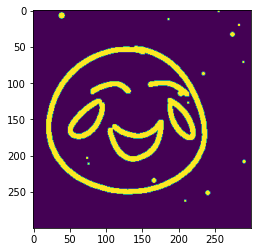

In [ ]:
for img,real in val_ds.take(1):
  i = 0
  pred = np.argmax(model.predict(img),-1)
  plt.imshow(img[i].numpy().squeeze(-1))
  print('actual: ',real.numpy()[i],'\npredicted: ',pred[i])

In [ ]:
m = tf.metrics.Accuracy()
for img, real in val_ds:
  pred = np.argmax(model.predict(img),-1)
  m.update_state(real, pred)
print("Accuracy: ",m.result().numpy())

Accuracy:  0.93286216


In [ ]:
model.save(root + "emoji_model/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/mosaic/emoji_model/assets
